# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 40  #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
x = 30  # No of frames to select
y = 120 # Width of the image
z = 120 # Height of the image


def generator(source_path, folder_list, batch_size, y, z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)]  #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(y, z)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255

                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x, y, z, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(y, z)) ##default resample=1 or 'P' which indicates PIL.Image.NEAREST
                    resized_image = resized_image/255 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM


#### Important functions

In [7]:

## Conv3d model with variable epoc count, batch_size and image_size
def cov3d_model(num_epocs, batch_size, image_width_height) :
    model_conv3d = Sequential()       
    model_conv3d.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, image_width_height, image_width_height, 3),padding='same'))
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(Activation('relu'))

    model_conv3d.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_conv3d.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_conv3d.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_conv3d.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))      

    # Flatten layer 
    model_conv3d.add(Flatten())
    model_conv3d.add(Dense(1000, activation='relu'))
    model_conv3d.add(Dropout(0.5))

    model_conv3d.add(Dense(500, activation='relu'))
    model_conv3d.add(Dropout(0.5))

    #Softmax layer
    model_conv3d.add(Dense(5, activation='softmax'))
    
    return  model_conv3d

In [8]:
## Variation to above Conv3d model with additional dropout at dense layer
def cov3d_model_with_dropout_at_dense(num_epocs, batch_size, image_width_height) :
    model_conv3d = Sequential()       
    model_conv3d.add(Conv3D(8,kernel_size=(3,3,3),input_shape=(30, image_width_height, image_width_height, 3),padding='same'))
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(Activation('relu'))

    model_conv3d.add(Conv3D(16, (3, 3, 3), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model_conv3d.add(Conv3D(32, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model_conv3d.add(Dropout(0.25))


    model_conv3d.add(Conv3D(64, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model_conv3d.add(Dropout(0.25))

    model_conv3d.add(Conv3D(128, (2, 2, 2), activation='relu', padding='same')) 
    model_conv3d.add(BatchNormalization())
    model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))      
    model_conv3d.add(Dropout(0.25))

    # Flatten layer 
    model_conv3d.add(Flatten())
    model_conv3d.add(Dense(1000, activation='relu'))
    model_conv3d.add(Dropout(0.5))

    model_conv3d.add(Dense(500, activation='relu'))
    model_conv3d.add(Dropout(0.5))

    #Softmax layer
    model_conv3d.add(Dense(5, activation='softmax'))
    
    return  model_conv3d

In [9]:
# RNN LSTM Model
def conv2d_rnn_lstm_architecture(num_epocs, batch_size, image_width_height):
    model_rnn_lstm = Sequential()   
    model_rnn_lstm.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'), input_shape=(30, image_width_height, image_width_height, 3)))
    model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
    model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_lstm.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
    model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
    model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_rnn_lstm.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
    model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_lstm.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
    model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_lstm.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_rnn_lstm.add(TimeDistributed(BatchNormalization()))
    model_rnn_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten layer 
    model_rnn_lstm.add(TimeDistributed(Flatten()))
    model_rnn_lstm.add(LSTM(256))
    model_rnn_lstm.add(Dropout(0.25))

    # Dense layer 
    model_rnn_lstm.add(Dense(128,activation='relu'))
    model_rnn_lstm.add(Dropout(0.25))

    # Softmax layer
    model_rnn_lstm.add(Dense(5, activation='softmax'))
    
    return model_rnn_lstm
    

In [10]:
#Conv2d and RNN GRU architecture
def rnn_gru_architecture(num_epocs, batch_size, image_width_height):
    model_rnn_gru = Sequential()   
    model_rnn_gru.add(TimeDistributed(Conv2D(8, (3, 3), padding='same', activation='relu'), input_shape=(30, image_width_height, image_width_height, 3)))
    model_rnn_gru.add(TimeDistributed(BatchNormalization()))
    model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_gru.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
    model_rnn_gru.add(TimeDistributed(BatchNormalization()))
    model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))
        
    model_rnn_gru.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
    model_rnn_gru.add(TimeDistributed(BatchNormalization()))
    model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_gru.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
    model_rnn_gru.add(TimeDistributed(BatchNormalization()))
    model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

    model_rnn_gru.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
    model_rnn_gru.add(TimeDistributed(BatchNormalization()))
    model_rnn_gru.add(TimeDistributed(MaxPooling2D((2, 2))))

    # Flatten layer 
    model_rnn_gru.add(TimeDistributed(Flatten()))
    model_rnn_gru.add(GRU(256))
    model_rnn_gru.add(Dropout(0.25))

    # Dense layer 
    model_rnn_gru.add(Dense(128,activation='relu'))
    model_rnn_gru.add(Dropout(0.25))

    # Softmax layer
    model_rnn_gru.add(Dense(5, activation='softmax'))
    
    return model_rnn_gru

In [11]:
# The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.
def calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch, validation_steps

In [12]:
import matplotlib.pyplot as plt

def plot(result):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(result.history['loss'])   
    axes[0].plot(result.history['val_loss'])
    axes[0].grid()
    axes[0].legend(['loss','val_loss'])
    axes[1].plot(result.history['categorical_accuracy'])   
    axes[1].plot(result.history['val_categorical_accuracy'])
    axes[1].grid()
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# Note change the parameter to False, else disk would run out of space.

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

## Model-1 : Conv3d architecture [epochs: 15, batch size: 40, Image size: 120x120]

First, lets run with less no. of epocs to see how the model fits

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-1- Conv3d  |15 |40 | 120x20 |




In [12]:
num_epochs = 15
batch_size = 40
image_width_height = 120

model_1 = cov3d_model(num_epochs,batch_size,image_width_height)

2022-05-15 11:46:35.545422: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-15 11:46:35.545488: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)



=========== Training the model ===========




Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/15


2022-05-15 11:46:46.890571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 6.3597 - categorical_accuracy: 0.3469Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.58338, saving model to model_init_2022-05-1511_46_32.929470/model-00001-6.35975-0.34691-1.58338-0.33000.h5
17/17 [==============================] - 176s 10s/step - loss: 6.3597 - categorical_accuracy: 0.3469 - val_loss: 1.5834 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.6867 - categorical_accuracy: 0.5269
Epoch 00002: val_loss did not improve from 1.58338
17/17 [==============================] - 101s 6s/step - loss: 1.6867 - categorical_accuracy: 0.5269 - val_loss: 4.5573 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 1.3152 - categorical_accuracy: 0.6213
Epoch 00003: val_loss did not improve from 1.58338

Epoch 00003: ReduceLROnPlateau reducin

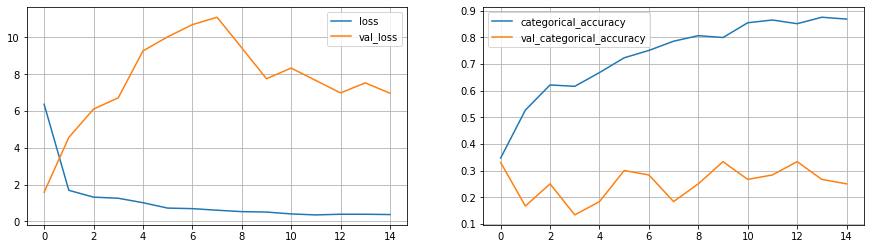

In [16]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-1</b> <br><br> Conv3d <br> epchs:15 <br> batch size: 40 <br> image size: 120x20 | 86.85 | 25.00 |


#### <b>Observations:
1. Model generated is overfitted with high training accuracy ad low validation accuracy. 
2. We should perform hyperparameter tuning to see if we could solve the issue of overfitting. 


## Model-2 : Conv3d architecture Hyperparamter tunned with higher epochs: 25

Lets run with higher epocs to see how the model fits

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-1- Conv3d  |25 |40 | 120x120 |





In [11]:
num_epochs = 25
batch_size = 40
image_width_height = 120

model_2 = cov3d_model(num_epochs,batch_size,image_width_height)

2022-05-15 19:16:36.957271: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-15 19:16:36.957346: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46483 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1b:00.0, compute capability: 8.6


In [12]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)



=========== Training the model ===========




In [14]:
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/25


2022-05-15 19:16:58.807110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2022-05-15 19:17:01.195113: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - ETA: 0s - loss: 7.0397 - categorical_accuracy: 0.3258Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.68381, saving model to model_init_2022-05-1519_15_30.389255/model-00001-7.03973-0.32579-1.68381-0.25000.h5
17/17 [==============================] - 154s 9s/step - loss: 7.0397 - categorical_accuracy: 0.3258 - val_loss: 1.6838 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
17/17 [==============================] - ETA: 0s - loss: 1.7951 - categorical_accuracy: 0.4348
Epoch 00002: val_loss did not improve from 1.68381
17/17 [==============================] - 92s 6s/step - loss: 1.7951 - categorical_accuracy: 0.4348 - val_loss: 3.6890 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/25
17/17 [==============================] - ETA: 0s - loss: 1.4400 - categorical_accuracy: 0.5586
Epoch 00003: val_loss did not improve from 1.68381

Epoch 00003: ReduceLROnPlateau reducing 

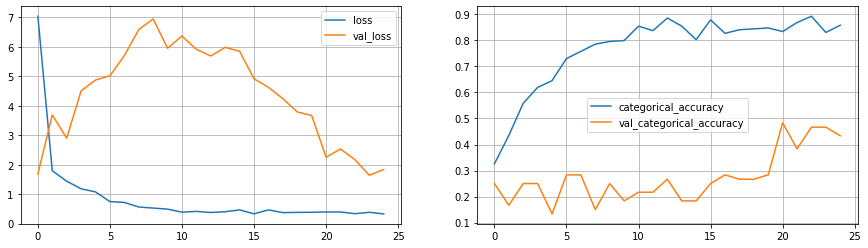

In [15]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-2</b> <br><br> Conv3d <br> epchs:25 <br> batch size: 40 <br> image size: 120x20 | 85.81 | 43.33 |


#### <b>Observations:
1. Model generated is still overfitted with high training accuracy ad low validation accuracy. 
2. Though the validation accuracy increased compared to previous but still it has issue of overfitt. 

## Model-3 : Conv3d architecture with Hyperparamter tuned  with even higher epoc=45

Lets run with higher epocs to see how the model fits

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-3- Conv3d  |45 |40 | 120x120 |



In [14]:
num_epochs = 45
batch_size = 40
image_width_height = 120

model_3 = cov3d_model(num_epochs,batch_size,image_width_height)


2022-05-17 06:29:50.771465: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-17 06:29:50.771527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1e:00.0, compute capability: 7.5


In [15]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_3.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)



=========== Training the model ===========




In [17]:
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/45


2022-05-17 06:30:10.560958: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 6.3779 - categorical_accuracy: 0.3379Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.61129, saving model to model_init_2022-05-1706_29_28.764179/model-00001-6.37788-0.33786-1.61129-0.33000.h5
17/17 [==============================] - 164s 10s/step - loss: 6.3779 - categorical_accuracy: 0.3379 - val_loss: 1.6113 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/45
17/17 [==============================] - ETA: 0s - loss: 1.6425 - categorical_accuracy: 0.4962
Epoch 00002: val_loss did not improve from 1.61129
17/17 [==============================] - 97s 6s/step - loss: 1.6425 - categorical_accuracy: 0.4962 - val_loss: 4.2830 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/45
17/17 [==============================] - ETA: 0s - loss: 1.3421 - categorical_accuracy: 0.5858
Epoch 00003: val_loss did not improve from 1.61129

Epoch 00003: ReduceLROnPlateau reducing

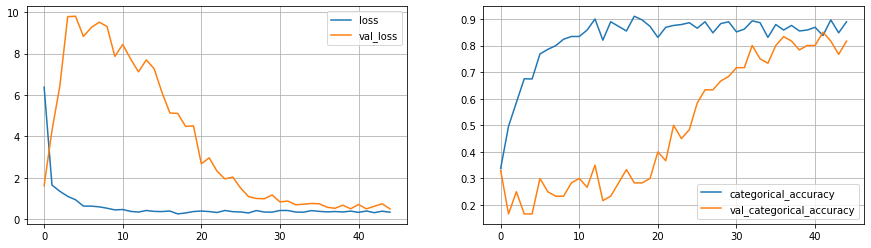

In [18]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-3</b> <br><br> Conv3d <br> epchs:45 <br> batch size: 40 <br> image size: 120x20 | 88.93 | 81.673 |


#### <b>Observations:
1. We obtained a very good training and validation accuracy. Also, the training loss and validation loss is also low. 

## Model-4 : Conv3d architecture with image size=150x150

Lets run with higher epocs to see how the model fits

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-4- Conv3d  |45 |40 | 150x150 |



In [21]:
num_epochs = 45
batch_size = 40
image_width_height = 150

In [22]:
model_4 = cov3d_model(num_epochs,batch_size,image_width_height)


In [23]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_4.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 30, 150, 150, 8)   656       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 150, 150, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 150, 150, 8)   0         
                                                                 
 conv3d_6 (Conv3D)           (None, 30, 150, 150, 16)  3472      
                                                                 
 batch_normalization_6 (Batc  (None, 30, 150, 150, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 75, 75, 16)  


print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)


In [25]:
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/45
17/17 [==============================] - ETA: 0s - loss: 11.1214 - categorical_accuracy: 0.2881Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss did not improve from 0.41256
17/17 [==============================] - 176s 10s/step - loss: 11.1214 - categorical_accuracy: 0.2881 - val_loss: 2.1217 - val_categorical_accuracy: 0.3300 - lr: 0.0010
Epoch 2/45
17/17 [==============================] - ETA: 0s - loss: 3.0545 - categorical_accuracy: 0.4194
Epoch 00002: val_loss did not improve from 0.41256
17/17 [==============================] - 103s 6s/step - loss: 3.0545 - categorical_accuracy: 0.4194 - val_loss: 4.3754 - val_categorical_accuracy: 0.1833 - lr: 0.0010
Epoch 3/45
17/17 [==============================] - ETA: 0s - loss: 2.4890 - categorical_accuracy: 0.4523
Epoch 00003: val_loss did not improve from 0.41256

Epoch 00003: ReduceLROnPlateau reducing learning rate to

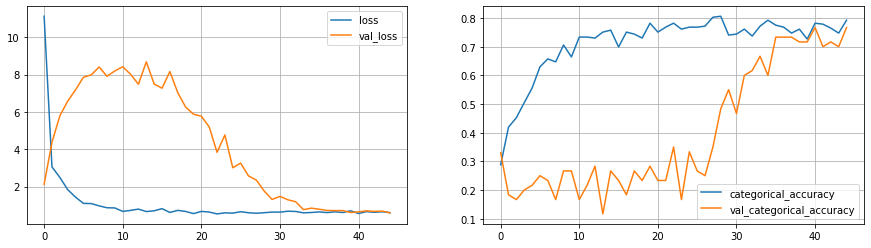

In [26]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-4</b> <br><br> Conv3d <br> epchs:45 <br> batch size: 40 <br> image size: 150x150 | 79.24 | 76.67 |


#### <b>Observations:
1. With 150x150 image size, both training and validation accuracy obtained were good but less than the one obtained with lower resolution(120x120) images.
2. We would revert to our 120x120 size images for further tuning. 

## Model-5 : Conv3d architecture with lower batch size =30 

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-5- Conv3d  |45 |30 | 120x120 |

In [11]:
num_epochs = 45
batch_size = 30
image_width_height = 120

model_5 = cov3d_model(num_epochs,batch_size,image_width_height)


2022-05-16 06:27:45.728304: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 06:27:45.728377: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [12]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)

#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)





=========== Training the model ===========


23
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/45


2022-05-16 06:28:00.410714: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 6.6208 - categorical_accuracy: 0.3243Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 1.55090, saving model to model_init_2022-05-1606_27_18.594280/model-00001-6.62078-0.32428-1.55090-0.31000.h5
23/23 [==============================] - 191s 8s/step - loss: 6.6208 - categorical_accuracy: 0.3243 - val_loss: 1.5509 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/45
23/23 [==============================] - ETA: 0s - loss: 2.6737 - categorical_accuracy: 0.3768
Epoch 00002: val_loss did not improve from 1.55090
23/23 [==============================] - 36s 2s/step - loss: 2.6737 - categorical_accuracy: 0.3768 - val_loss: 5.1600 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 3/45
23/23 [==============================] - ETA: 0s - loss: 3.6362 - categorical_accuracy: 0.2609
Epoch 00003: val_loss did not improve from 1.55090

Epoch 00003: ReduceLROnPlateau reducing 

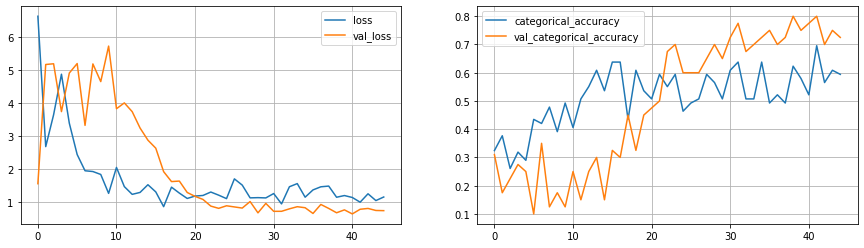

In [14]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-5</b> <br><br> Conv3d <br> epchs:45 <br> batch size: 30 <br> image size: 120x120 | 59.42 | 72.50 |


#### <b>Observations:
1. The validation accuracy dropped significantly with decreased batch size to 30. 


## Model-6 : Conv3d architecture with higher batch size =50

| Model | epochs | batch size | Image size |
| :-- | :-: | :-: |:-----:|
| Model-6- Conv3d  |45 |50  | 120x120 |

In [11]:
num_epochs = 45
batch_size = 50
image_width_height = 120

model_6 = cov3d_model(num_epochs,batch_size,image_width_height)

2022-05-16 07:50:19.760273: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 07:50:19.760344: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [12]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_6.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:

print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)


#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




=========== Training the model ===========


14
Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/45


2022-05-16 07:50:36.098620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 7.1194 - categorical_accuracy: 0.3152 Source path =  /home/datasets/Project_data/val ; batch size = 50

Epoch 00001: val_loss improved from inf to 1.98320, saving model to model_init_2022-05-1607_50_03.778452/model-00001-7.11939-0.31523-1.98320-0.16000.h5
14/14 [==============================] - 195s 14s/step - loss: 7.1194 - categorical_accuracy: 0.3152 - val_loss: 1.9832 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/45
14/14 [==============================] - ETA: 0s - loss: 2.2067 - categorical_accuracy: 0.4505
Epoch 00002: val_loss did not improve from 1.98320
14/14 [==============================] - 84s 6s/step - loss: 2.2067 - categorical_accuracy: 0.4505 - val_loss: 4.4632 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/45
14/14 [==============================] - ETA: 0s - loss: 2.0172 - categorical_accuracy: 0.4396
Epoch 00003: val_loss did not improve from 1.98320

Epoch 00003: ReduceLROnPlateau reducin

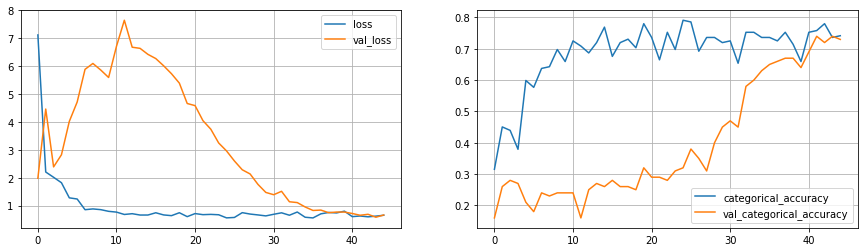

In [14]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-6</b> <br><br> Conv3d <br> epchs:45 <br> batch size: 50 <br> image size: 120x120 | 74.18 | 73.00|


#### <b>Observations:
1. The validation and training accuracy improved but still less than model-3. we would continue to consider model-3 as our base model.


## Model-7 : Conv3d architecture with SGD optimizer

| Model | epochs | batch size | Image size | Optimizer|
| :-- | :-: | :-: |:-----:|:----:|
| Model-7- Conv3d  |45 |50  | 120x120 | sgd |

In [14]:
num_epochs = 45
batch_size = 40
image_width_height = 120

model_7 = cov3d_model(num_epochs,batch_size,image_width_height)


2022-05-18 14:48:42.448696: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-18 14:48:42.448754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22846 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [15]:
optimiser = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True) #write your optimizer
model_7.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)

#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




=========== Training the model ===========


17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/45


2022-05-18 14:48:53.069480: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 3.2016 - categorical_accuracy: 0.2670Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.58230, saving model to model_init_2022-05-1814_48_21.017492/model-00001-3.20158-0.26697-1.58230-0.34000.h5
17/17 [==============================] - 163s 10s/step - loss: 3.2016 - categorical_accuracy: 0.2670 - val_loss: 1.5823 - val_categorical_accuracy: 0.3400 - lr: 0.0010
Epoch 2/45
17/17 [==============================] - ETA: 0s - loss: 1.8009 - categorical_accuracy: 0.4143
Epoch 00002: val_loss improved from 1.58230 to 1.57789, saving model to model_init_2022-05-1814_48_21.017492/model-00002-1.80092-0.41432-1.57789-0.28333.h5
17/17 [==============================] - 94s 6s/step - loss: 1.8009 - categorical_accuracy: 0.4143 - val_loss: 1.5779 - val_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 3/45
17/17 [==============================] - ETA: 0s - loss: 1.3366 - categorical_acc

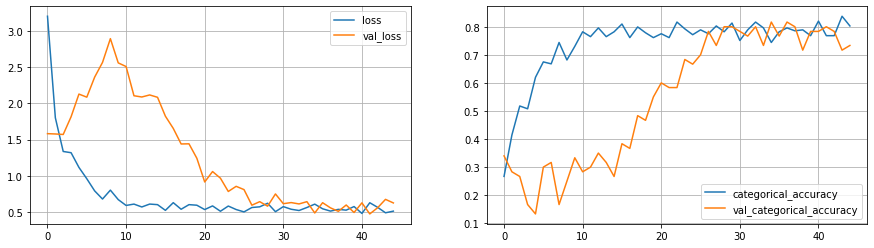

In [ ]:
plot(result)

## Model-8 : Conv3d architecture with additional droput at dense layer

| Model | epochs | batch size | Image size | 
| :-- | :-: | :-: |:-----:|
| Conv3d with <br>additional droput <br> at dense layers |45 |40  | 120x120 |

In [12]:
num_epochs = 45
batch_size = 40
image_width_height = 120

model_8 = cov3d_model_with_dropout_at_dense(num_epochs,batch_size,image_width_height)

2022-05-16 18:27:22.145382: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 18:27:22.145442: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [13]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_8.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_8.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:

print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)


#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




=========== Training the model ===========


17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/45


2022-05-16 18:27:39.543293: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 8.4450 - categorical_accuracy: 0.3002Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 3.68090, saving model to model_init_2022-05-1618_26_54.867201/model-00001-8.44504-0.30015-3.68090-0.21000.h5
17/17 [==============================] - 159s 9s/step - loss: 8.4450 - categorical_accuracy: 0.3002 - val_loss: 3.6809 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/45
17/17 [==============================] - ETA: 0s - loss: 2.0321 - categorical_accuracy: 0.4169
Epoch 00002: val_loss did not improve from 3.68090
17/17 [==============================] - 92s 6s/step - loss: 2.0321 - categorical_accuracy: 0.4169 - val_loss: 9.1806 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/45
17/17 [==============================] - ETA: 0s - loss: 1.6889 - categorical_accuracy: 0.4877
Epoch 00003: val_loss did not improve from 3.68090

Epoch 00003: ReduceLROnPlateau reducing 

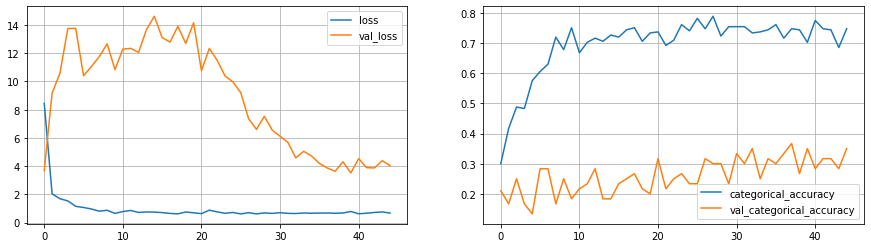

In [15]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-8</b> <br><br> Conv3d with additional dropouts<br> at dense layer <br> epchs:45 <br> batch size: 50 <br> image size: 120x120 | 74.74 | 35.00|


#### <b>Observations:
1. The validation frequency dropped significantly which means we should reject this model. 


## Model-9 : Conv2d+LSTM architecture with additional droput at dense layer

| Model | epochs | batch size | Image size | 
| :-- | :-: | :-: |:-----:|
| Conv2d +  LSTM  |45 |40  | 120x120 |

In [34]:
num_epochs = 45
batch_size = 40
image_width_height = 120

model_9 = conv2d_rnn_lstm_architecture(num_epochs,batch_size,image_width_height)

In [35]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_9.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_9.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 16)  

In [1]:


print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)


#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)




=========== Training the model ===========




NameError: name 'generator' is not defined

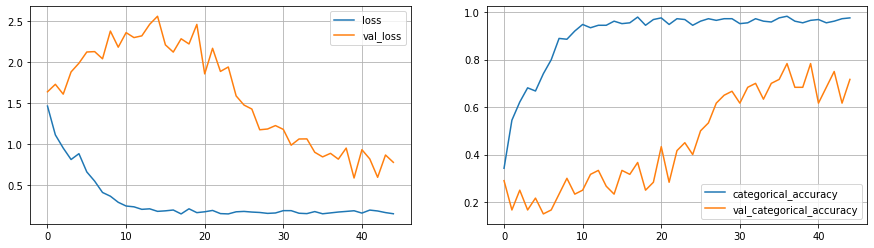

In [37]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-9</b> <br><br> Conv2d with <br> LSTM based architecture <br> epchs:45 <br> batch size: 50 <br> image size: 120x120 | 97.58 | 71.67|


#### <b>Observations:
1. Highly overfitted model with high training accuracy and low validation accuracy.

## Model-10 : Conv2d+GRU architecture with additional droput at dense layer

| Model | epochs | batch size | Image size | 
| :-- | :-: | :-: |:-----:|
| Conv2d +  GRU  |45 |40  | 120x120 |

In [14]:
num_epochs = 45
batch_size = 40
image_width_height = 120

model_10 = rnn_gru_architecture(num_epochs,batch_size,image_width_height)

2022-05-16 20:30:27.661342: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-16 20:30:27.661402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


In [15]:
optimiser = tf.keras.optimizers.Adam(lr=0.001) #write your optimizer
model_10.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_10.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 8)  224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 8)  32        
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 8)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 16)   6

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:

print('\n\n=========== Training the model ===========\n\n')
train_generator = generator(train_path, train_doc, batch_size, image_width_height, image_width_height)
val_generator = generator(val_path, val_doc, batch_size, image_width_height, image_width_height)




=========== Training the model ===========




In [17]:
#The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
steps_per_epoch, validation_steps = calculate_steps_per_epoch(batch_size, num_train_sequences, num_val_sequences)
print(steps_per_epoch)
# Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.
result = model_10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


17
Source path =  /home/datasets/Project_data/train ; batch size = 40
Epoch 1/45


2022-05-16 20:30:39.934229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


17/17 [==============================] - ETA: 0s - loss: 1.4372 - categorical_accuracy: 0.4103Source path =  /home/datasets/Project_data/val ; batch size = 40

Epoch 00001: val_loss improved from inf to 1.62406, saving model to model_init_2022-05-1620_30_08.082265/model-00001-1.43723-0.41026-1.62406-0.32000.h5
17/17 [==============================] - 157s 9s/step - loss: 1.4372 - categorical_accuracy: 0.4103 - val_loss: 1.6241 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/45
17/17 [==============================] - ETA: 0s - loss: 0.9109 - categorical_accuracy: 0.6650
Epoch 00002: val_loss did not improve from 1.62406
17/17 [==============================] - 93s 6s/step - loss: 0.9109 - categorical_accuracy: 0.6650 - val_loss: 2.2178 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 3/45
17/17 [==============================] - ETA: 0s - loss: 0.8168 - categorical_accuracy: 0.7084
Epoch 00003: val_loss did not improve from 1.62406

Epoch 00003: ReduceLROnPlateau reducing 

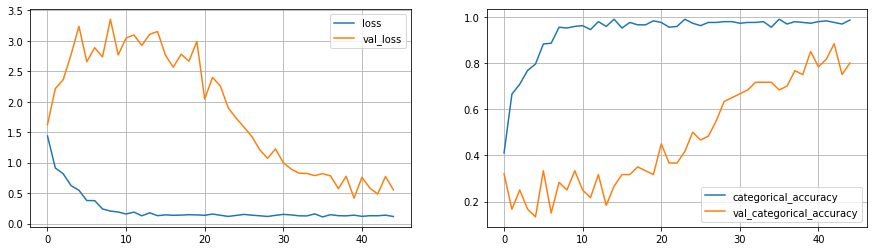

In [18]:
plot(result)

#### Output

| Model | Training Accuracy | Validation Accuracy |
| :-: | --: | --: |
|<b>Model-10</b> <br><br> Conv2d with <br> GRU based architecture <br> epchs:45 <br> batch size: 50 <br> image size: 120x120 | 98.62 | 80.00|


#### <b>Observations:
1. Highly overfitted model with high training accuracy and low validation accuracy.

### Conclusion:
    
- A number of experiments were conducted with different image sizes (120x120, 150x150) with varying combinations of batch sizes (30, 40, 50), epochs (25,50) to train the model. As part of the exercise Conv3D architecture, LSTM, GPU and conv2D architecture was used. Outcomes are listed below:
 - Conv3d architecture
 - LSTM architecture
 - GRU atchitecture 
 
 Where Conv3d architecture seems to perform better compared to LSTM & GPU. 
 